## Data pipeline RAG to MedLM

In [1]:
from google.cloud import aiplatform
from google.cloud.aiplatform.gapic.schema import predict
from google.protobuf import json_format
from google.protobuf.struct_pb2 import Value

In [2]:
from langchain.llms import OpenAI
from langchain.prompts import PromptTemplate
from google.cloud import bigquery
from langchain_openai import ChatOpenAI

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
from langchain_experimental.sql import SQLDatabaseChain
from langchain.sql_database import SQLDatabase
from langchain.prompts import PromptTemplate

In [5]:
openai_api_key = openai_api_key

In [6]:
#llm = ChatOpenAI(openai_api_key=openai_api_key, model="gpt-4")
#llm.invoke("what can you help me with?")

# Question 1

In [8]:
# Initialize BigQuery client
bigquery_client = bigquery.Client()

# Define the Openai model
llm = ChatOpenAI(openai_api_key=openai_api_key, model="gpt-4-32k")

# Manually define the SQLDatabase
# Assume you have a BigQuery connection string or credentials file
connection_string = "bigquery://us-gcp-ame-con-5b680-sbx-1/mimic_iv_hosp_icu_dataset"

# Create the SQLDatabase instance
db = SQLDatabase.from_uri(connection_string)

# Create the SQLDatabaseChain
chain = SQLDatabaseChain(llm=llm, database=db)

# Define your natural language query
natural_language_query = "List of medication used to treat patients with pain join with admissions limit 1"

# Generate SQL and execute
sql_query = chain.run(natural_language_query)
print("Generated SQL:", sql_query)

Generated SQL: The medication 'Papain 2.5 % Solution' was used to treat a patient with id 12749568, who was admitted on 2136-11-09 15:59:00 and discharged on 2136-12-10 14:00:00.


In [10]:
client_options = {"api_endpoint": "us-central1-aiplatform.googleapis.com"}

# Initialize client that will be used to create and send requests.

# This client only needs to be created once, and can be reused for multiple requests.

client = aiplatform.gapic.PredictionServiceClient(

    client_options=client_options

)
instance_dict = { "content": "Summarize " + sql_query }

instance = json_format.ParseDict(instance_dict, Value())

instances = [instance]

parameters_dict = {

    "candidateCount": 1,

    "maxOutputTokens": 500,

    "temperature": 0.2,

    "topP": 0.8,

    "topK": 40

}

parameters = json_format.ParseDict(parameters_dict, Value())

response = client.predict(

    endpoint="projects/us-gcp-ame-con-5b680-sbx-1/locations/us-central1/publishers/google/models/medlm-large", instances=instances, parameters=parameters

)

print("response")

predictions = response.predictions

for prediction in predictions:
    print(" prediction:", dict(prediction))

response
 prediction: {'content': ' Papain 2.5% solution is a medication that is used to treat a variety of conditions. It is a proteolytic enzyme, which means that it helps to break down proteins. Papain is derived from the papaya fruit, and it has been used for centuries to treat a variety of medical conditions. Papain 2.5% solution can be used to treat a variety of conditions, including: Wounds: Papain can help to clean and debride wounds, and it can also help to promote healing. Skin conditions: Papain can be used to treat a variety of skin conditions, such as acne, eczema, and psoriasis. Digestive problems: Papain can help to improve digestion and relieve symptoms of indigestion, such as heartburn and bloating. Inflammation: Papain can help to reduce inflammation in the body. Papain 2.5% solution is a safe and effective medication that can be used to treat a variety of conditions. It is important to follow the directions on the medication label and to talk to your doctor or pharma

In [1]:
from sentence_transformers import SentenceTransformer, util

# Load a pre-trained sentence embedding model
model = SentenceTransformer('all-mpnet-base-v2')

# Your MedLM output
medlm_output = "Papain 2.5% solution is a medication that is used to treat a variety of conditions. It is a proteolytic enzyme, which means that it helps to break down proteins. Papain is derived from the papaya fruit, and it has been used for centuries to treat a variety of medical conditions. Papain 2.5% solution can be used to treat a variety of conditions, including: Wounds: Papain can help to clean and debride wounds, and it can also help to promote healing. Skin conditions: Papain can be used to treat a variety of skin conditions, such as acne, eczema, and psoriasis. Digestive problems: Papain can help to improve digestion and relieve symptoms of indigestion, such as heartburn and bloating. Inflammation: Papain can help to reduce inflammation in the body. Papain 2.5% solution is a safe and effective medication that can be used to treat a variety of conditions. It is important to follow the directions on the medication label and to talk to your doctor or pharmacist if you have any questions about papain 2.5% solution."
# Your reference text
rag_output = "The medication 'Papain 2.5 % Solution' was used to treat a patient with id 12749568, who was admitted on 2136-11-09"

# Encode the sentences into vectors
medlm_embedding = model.encode(medlm_output)
reference_embedding = model.encode(rag_output)

# Calculate cosine similarity
cosine_similarity = util.cos_sim(medlm_embedding, reference_embedding)[0][0]

print(f"Cosine Similarity: {cosine_similarity}")

/opt/conda/lib/python3.10/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
2024-08-08 13:08:28.172782: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-08 13:08:28.200350: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-08 13:08:28.207993: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Cosine Similarity: 0.6605226993560791


# Question 2

In [7]:
# Initialize BigQuery client
bigquery_client = bigquery.Client()

# Define the Openai model
llm = ChatOpenAI(openai_api_key=openai_api_key, model="gpt-4-32k")

# Manually define the SQLDatabase
# Assume you have a BigQuery connection string or credentials file
connection_string = "bigquery://us-gcp-ame-con-5b680-sbx-1/mimic_iv_hosp_icu_dataset"

# Create the SQLDatabase instance
db = SQLDatabase.from_uri(connection_string)

# Create the SQLDatabaseChain
chain = SQLDatabaseChain(llm=llm, database=db)

# Define your natural language query
natural_language_query = "What is the most frequently prescribed prescription drug"

# Generate SQL and execute
sql_query = chain.run(natural_language_query)
print("Generated SQL:", sql_query)


Generated SQL: The most frequently prescribed prescription drug is Insulin.


In [8]:
# The AI Platform services require regional API endpoints.

client_options = {"api_endpoint": "us-central1-aiplatform.googleapis.com"}

# Initialize client that will be used to create and send requests.

# This client only needs to be created once, and can be reused for multiple requests.

client = aiplatform.gapic.PredictionServiceClient(

    client_options=client_options

)

instance_dict = { "content": "Summarize " + sql_query }

instance = json_format.ParseDict(instance_dict, Value())

instances = [instance]

parameters_dict = {

    "candidateCount": 1,

    "maxOutputTokens": 500,

    "temperature": 0.2,

    "topP": 0.8,

    "topK": 40

}

parameters = json_format.ParseDict(parameters_dict, Value())

response = client.predict(

    endpoint="projects/us-gcp-ame-con-5b680-sbx-1/locations/us-central1/publishers/google/models/medlm-large", instances=instances, parameters=parameters

)

print("response")

predictions = response.predictions

for prediction in predictions:
    print(" prediction:", dict(prediction))

response
 prediction: {'content': " Insulin is a hormone that is produced by the pancreas and is essential for the body's use of glucose (sugar) for energy. It is used to treat diabetes, a condition in which the body does not produce enough insulin or does not use insulin effectively. Insulin is available in several different forms, including injectable, oral, and inhaled forms. The type and dose of insulin that is prescribed will depend on the individual's needs.", 'safetyAttributes': <proto.marshal.collections.maps.MapComposite object at 0x7f01defcb880>, 'citationMetadata': <proto.marshal.collections.maps.MapComposite object at 0x7f01defcbfd0>}


# Question 3

In [9]:
# Initialize BigQuery client
bigquery_client = bigquery.Client()

# Define the Openai model
llm = ChatOpenAI(openai_api_key=openai_api_key, model="gpt-4-32k")

# Manually define the SQLDatabase
# Assume you have a BigQuery connection string or credentials file
connection_string = "bigquery://us-gcp-ame-con-5b680-sbx-1/mimic_iv_hosp_icu_dataset"

# Create the SQLDatabase instance
db = SQLDatabase.from_uri(connection_string)

# Create the SQLDatabaseChain
chain = SQLDatabaseChain(llm=llm, database=db)

# Define your natural language query
natural_language_query = "Provider order entries (poe) most frequent order type limit 5"

# Generate SQL and execute
sql_query = chain.run(natural_language_query)
print("Generated SQL:", sql_query)

Generated SQL: The most frequent order types in provider order entries are:
1. Medications with 17690066 entries
2. Lab with 6565578 entries
3. General Care with 5690221 entries
4. ADT orders with 2171456 entries
5. IV therapy with 2140236 entries


In [10]:
# The AI Platform services require regional API endpoints.

client_options = {"api_endpoint": "us-central1-aiplatform.googleapis.com"}

# Initialize client that will be used to create and send requests.

# This client only needs to be created once, and can be reused for multiple requests.

client = aiplatform.gapic.PredictionServiceClient(

    client_options=client_options

)

instance_dict = { "content": "Summarize " + sql_query }

instance = json_format.ParseDict(instance_dict, Value())

instances = [instance]

parameters_dict = {

    "candidateCount": 1,

    "maxOutputTokens": 500,

    "temperature": 0.2,

    "topP": 0.8,

    "topK": 40

}

parameters = json_format.ParseDict(parameters_dict, Value())

response = client.predict(

    endpoint="projects/us-gcp-ame-con-5b680-sbx-1/locations/us-central1/publishers/google/models/medlm-large", instances=instances, parameters=parameters

)

print("response")

predictions = response.predictions

for prediction in predictions:
    print(" prediction:", dict(prediction))

response
 prediction: {'content': ' The most frequent order types in provider order entries are:\n1. Medications: 17690066 entries\n2. Lab: 6565578 entries\n3. General Care: 5690221 entries\n4. ADT orders: 2171456 entries\n5. IV therapy: 2140236 entries\n\nMedications are the most common type of order, accounting for over half of all orders. This is likely due to the fact that medications are a common form of treatment for many different medical conditions. Lab orders are also common, as they are often used to diagnose and monitor medical conditions. General care orders include a variety of different types of orders, such as orders for diet, activity, and wound care. ADT orders are used to admit, discharge, and transfer patients. IV therapy is used to administer fluids and medications intravenously.', 'citationMetadata': <proto.marshal.collections.maps.MapComposite object at 0x7f01defcbeb0>, 'safetyAttributes': <proto.marshal.collections.maps.MapComposite object at 0x7f01fd760400>}


# Question 4 

In [11]:
# Initialize BigQuery client
bigquery_client = bigquery.Client()

# Define the Openai model
llm = ChatOpenAI(openai_api_key=openai_api_key, model="gpt-4-32k")

# Manually define the SQLDatabase
# Assume you have a BigQuery connection string or credentials file
connection_string = "bigquery://us-gcp-ame-con-5b680-sbx-1/mimic_iv_hosp_icu_dataset"

# Create the SQLDatabase instance
db = SQLDatabase.from_uri(connection_string)

# Create the SQLDatabaseChain
chain = SQLDatabaseChain(llm=llm, database=db)

# Define your natural language query
natural_language_query = "What are the unique name of the tests given to patients who were admitted and the doctor comments VRE isolated limit 3 "

# Generate SQL and execute
sql_query = chain.run(natural_language_query)
print("Generated SQL:", sql_query)

Generated SQL: The unique names of the tests given to patients who were admitted and the doctor comments "VRE isolated" are 'R/O VANCOMYCIN RESISTANT ENTEROCOCCUS', 'WOUND CULTURE', and 'FECAL CULTURE - R/O VIBRIO'.


In [12]:
# The AI Platform services require regional API endpoints.

client_options = {"api_endpoint": "us-central1-aiplatform.googleapis.com"}

# Initialize client that will be used to create and send requests.

# This client only needs to be created once, and can be reused for multiple requests.

client = aiplatform.gapic.PredictionServiceClient(

    client_options=client_options

)

instance_dict = { "content": "Summarize " + sql_query }

instance = json_format.ParseDict(instance_dict, Value())

instances = [instance]

parameters_dict = {

    "candidateCount": 1,

    "maxOutputTokens": 500,

    "temperature": 0.2,

    "topP": 0.8,

    "topK": 40

}

parameters = json_format.ParseDict(parameters_dict, Value())

response = client.predict(

    endpoint="projects/us-gcp-ame-con-5b680-sbx-1/locations/us-central1/publishers/google/models/medlm-large", instances=instances, parameters=parameters

)

print("response")

predictions = response.predictions

for prediction in predictions:
    print(" prediction:", dict(prediction))

response
 prediction: {'safetyAttributes': <proto.marshal.collections.maps.MapComposite object at 0x7f01fd760370>, 'content': " Vancomycin-resistant Enterococcus (VRE) is a type of bacteria that is resistant to the antibiotic vancomycin. VRE can cause serious infections, especially in people who are hospitalized or have weakened immune systems. VRE is often found in hospitals and other healthcare settings, where it can be spread from person to person through contact with contaminated surfaces or objects. The tests listed above are used to diagnose VRE infections. The 'R/O VANCOMYCIN RESISTANT ENTEROCOCCUS' test is a culture test that is used to identify VRE bacteria in a sample of stool, urine, or blood. The 'WOUND CULTURE' test is used to identify bacteria that may be causing an infection in a wound. The 'FECAL CULTURE - R/O VIBRIO' test is used to identify Vibrio bacteria, which can cause a type of food poisoning. If you have any questions about these tests, please talk to your docto

# Question 5

In [8]:
# Initialize BigQuery client
bigquery_client = bigquery.Client()

# Define the Openai model
llm = ChatOpenAI(openai_api_key=openai_api_key, model="gpt-4-32k")

# Manually define the SQLDatabase
# Assume you have a BigQuery connection string or credentials file
connection_string = "bigquery://us-gcp-ame-con-5b680-sbx-1/mimic_iv_dataset"

# Create the SQLDatabase instance
db = SQLDatabase.from_uri(connection_string)

# Create the SQLDatabaseChain
chain = SQLDatabaseChain(llm=llm, database=db)

# Define your natural language query
natural_language_query = "What is the radiology findings of a patient who received ORTHOPAEDICS service in discharge text limit 1"

# Generate SQL and execute
sql_query = chain.run(natural_language_query)
print("Generated SQL:", sql_query)

Generated SQL: The radiology findings of a patient who received ORTHOPAEDICS service in discharge text are: "EXAMINATION:  CHEST (PORTABLE AP)\n\nINDICATION:  ___ year old woman with urosepsis with fever  // rule out\npneumonia\n\nTECHNIQUE:  CHEST (PORTABLE AP)\n\nCOMPARISON:  ___\n\nIMPRESSION: \n\nLeft internal jugular line tip is at the level of mid SVC.  Cardiomegaly is\nsubstantial, unchanged.  Sternal..."


In [9]:
# The AI Platform services require regional API endpoints.

client_options = {"api_endpoint": "us-central1-aiplatform.googleapis.com"}

# Initialize client that will be used to create and send requests.

# This client only needs to be created once, and can be reused for multiple requests.

client = aiplatform.gapic.PredictionServiceClient(

    client_options=client_options

)

instance_dict = { "content": "Summarize " + sql_query }

instance = json_format.ParseDict(instance_dict, Value())

instances = [instance]

parameters_dict = {

    "candidateCount": 1,

    "maxOutputTokens": 500,

    "temperature": 0.2,

    "topP": 0.8,

    "topK": 40

}

parameters = json_format.ParseDict(parameters_dict, Value())

response = client.predict(

    endpoint="projects/us-gcp-ame-con-5b680-sbx-1/locations/us-central1/publishers/google/models/medlm-large", instances=instances, parameters=parameters

)

print("response")

predictions = response.predictions

for prediction in predictions:
    print(" prediction:", dict(prediction))

response
 prediction: {'safetyAttributes': <proto.marshal.collections.maps.MapComposite object at 0x7f0785b6f850>, 'content': ' There is no evidence of pneumonia on the chest X-ray. The patient has a large heart (cardiomegaly) and a sternal wire, which is likely from previous surgery. The tip of the left internal jugular line is in a good position.', 'citationMetadata': <proto.marshal.collections.maps.MapComposite object at 0x7f0785b6f8b0>}


# Question 6

In [10]:
# Initialize BigQuery client
bigquery_client = bigquery.Client()

# Define the Openai model
llm = ChatOpenAI(openai_api_key=openai_api_key, model="gpt-4-32k")

# Manually define the SQLDatabase
# Assume you have a BigQuery connection string or credentials file
connection_string = "bigquery://us-gcp-ame-con-5b680-sbx-1/mimic_iv_dataset"

# Create the SQLDatabase instance
db = SQLDatabase.from_uri(connection_string)

# Create the SQLDatabaseChain
chain = SQLDatabaseChain(llm=llm, database=db)

# Define your natural language query
natural_language_query = "What is the radiology findings of a patient whose Chief Complaint is Abdominal pain in discharge text limit 1"

# Generate SQL and execute
sql_query = chain.run(natural_language_query)
print("Generated SQL:", sql_query)

Generated SQL: The radiology findings for the patient whose Chief Complaint was Abdominal pain in the discharge text were: "EXAMINATION:  CT ABD AND PELVIS WITH CONTRAST\n\nINDICATION:  ___ with history of feeding tube, purulent drainage from wound\nsite. Difficult venous access.NO_PO contrast// Abscess?  G-tube placement?\n\nTECHNIQUE:  Single phase contrast: MDCT axial images were acquired through the\nabdomen and pelvis..."


In [11]:
# The AI Platform services require regional API endpoints.

client_options = {"api_endpoint": "us-central1-aiplatform.googleapis.com"}

# Initialize client that will be used to create and send requests.

# This client only needs to be created once, and can be reused for multiple requests.

client = aiplatform.gapic.PredictionServiceClient(

    client_options=client_options

)

instance_dict = { "content": "Summarize " + sql_query }

instance = json_format.ParseDict(instance_dict, Value())

instances = [instance]

parameters_dict = {

    "candidateCount": 1,

    "maxOutputTokens": 500,

    "temperature": 0.2,

    "topP": 0.8,

    "topK": 40

}

parameters = json_format.ParseDict(parameters_dict, Value())

response = client.predict(

    endpoint="projects/us-gcp-ame-con-5b680-sbx-1/locations/us-central1/publishers/google/models/medlm-large", instances=instances, parameters=parameters

)

print("response")

predictions = response.predictions

for prediction in predictions:
    print(" prediction:", dict(prediction))

response
 prediction: {'safetyAttributes': <proto.marshal.collections.maps.MapComposite object at 0x7f0785c23370>, 'citationMetadata': <proto.marshal.collections.maps.MapComposite object at 0x7f0785bbffd0>, 'content': " There is no clear indication for the CT scan. The patient has a history of feeding tube, purulent drainage from wound site, and difficult venous access. The CT scan was done to evaluate for an abscess or to guide placement of a gastrostomy tube. The CT scan showed a small amount of free fluid in the right upper quadrant, which could be related to the patient's history of abdominal pain. There was no evidence of an abscess or other abnormality."}


# Question 7

In [12]:
# Initialize BigQuery client
bigquery_client = bigquery.Client()

# Define the Openai model
llm = ChatOpenAI(openai_api_key=openai_api_key, model="gpt-4-32k")

# Manually define the SQLDatabase
# Assume you have a BigQuery connection string or credentials file
connection_string = "bigquery://us-gcp-ame-con-5b680-sbx-1/mimic_iv_dataset"

# Create the SQLDatabase instance
db = SQLDatabase.from_uri(connection_string)

# Create the SQLDatabaseChain
chain = SQLDatabaseChain(llm=llm, database=db)

# Define your natural language query
natural_language_query = "What is the radiology findings of a patient who was discharged with a history of liver cirrhosis limit 2"

# Generate SQL and execute
sql_query = chain.run(natural_language_query)
print("Generated SQL:", sql_query)

Generated SQL: The patient with note_id '17829563-RR-2' had a CT HEAD W/O CONTRAST examination where they found 'Routine unenhanced head CT was performed and viewed in brain,\nintermediate and bone windows.  Coronal and sagittal reformats were also\nperformed.\n\nDOSE:  Total DLP (Head) = 903 mGy-cm.\n\nCOMPARISON: ...'. The patient with note_id '14707889-RR-3' was indicated with 'History of hep C without treatment.  Presenting with abdominal\ndistension.  Question cirrhosis.\n\nCOMPARISON:  None.\n\nFINDINGS:  The liver is shrunken and nodular in appearance consistent with\ncirrhosis.  There is no evidence of intrahepatic biliary duct dilatation.  The\ncommon bile...'.


In [13]:
# The AI Platform services require regional API endpoints.

client_options = {"api_endpoint": "us-central1-aiplatform.googleapis.com"}

# Initialize client that will be used to create and send requests.

# This client only needs to be created once, and can be reused for multiple requests.

client = aiplatform.gapic.PredictionServiceClient(

    client_options=client_options

)

instance_dict = { "content": "Summarize " + sql_query }

instance = json_format.ParseDict(instance_dict, Value())

instances = [instance]

parameters_dict = {

    "candidateCount": 1,

    "maxOutputTokens": 500,

    "temperature": 0.2,

    "topP": 0.8,

    "topK": 40

}

parameters = json_format.ParseDict(parameters_dict, Value())

response = client.predict(

    endpoint="projects/us-gcp-ame-con-5b680-sbx-1/locations/us-central1/publishers/google/models/medlm-large", instances=instances, parameters=parameters

)

print("response")

predictions = response.predictions

for prediction in predictions:
    print(" prediction:", dict(prediction))

response
 prediction: {'content': ' One of the patients had a CT scan of the head without contrast, which showed no abnormalities. The other patient had an ultrasound of the abdomen, which showed a shrunken and nodular liver consistent with cirrhosis. There was no evidence of intrahepatic biliary duct dilatation. The common bile duct was mildly dilated at 8 mm. The gallbladder was distended with stones and sludge.', 'safetyAttributes': <proto.marshal.collections.maps.MapComposite object at 0x7f07a04765c0>, 'citationMetadata': <proto.marshal.collections.maps.MapComposite object at 0x7f07a0476f50>}


# Question 8

In [21]:
# Initialize BigQuery client
bigquery_client = bigquery.Client()

# Define the Openai model
llm = ChatOpenAI(openai_api_key=openai_api_key, model="gpt-4-32k")

# Manually define the SQLDatabase
# Assume you have a BigQuery connection string or credentials file
connection_string = "bigquery://us-gcp-ame-con-5b680-sbx-1/mimic_iv_dataset"

# Create the SQLDatabase instance
db = SQLDatabase.from_uri(connection_string)

# Create the SQLDatabaseChain
chain = SQLDatabaseChain(llm=llm, database=db)

# Define your natural language query
natural_language_query = "What is the radiology findings of a patient with Past Medical History of coronary artery disease in discharge text limit 1"

# Generate SQL and execute
sql_query = chain.run(natural_language_query)
print("Generated SQL:", sql_query)

Generated SQL: The radiology findings of a patient with a past medical history of coronary artery disease are as follows: There is a mild homogeneous plaque in the proximal internal carotid artery without significant increase in peak systolic velocities. The peak systolic velocity in the common carotid artery is 86 cm/sec.


In [22]:
# The AI Platform services require regional API endpoints.

client_options = {"api_endpoint": "us-central1-aiplatform.googleapis.com"}

# Initialize client that will be used to create and send requests.

# This client only needs to be created once, and can be reused for multiple requests.

client = aiplatform.gapic.PredictionServiceClient(

    client_options=client_options

)

instance_dict = { "content": "Summarize " + sql_query }

instance = json_format.ParseDict(instance_dict, Value())

instances = [instance]

parameters_dict = {

    "candidateCount": 1,

    "maxOutputTokens": 500,

    "temperature": 0.2,

    "topP": 0.8,

    "topK": 40

}

parameters = json_format.ParseDict(parameters_dict, Value())

response = client.predict(

    endpoint="projects/us-gcp-ame-con-5b680-sbx-1/locations/us-central1/publishers/google/models/medlm-large", instances=instances, parameters=parameters

)

print("response")

predictions = response.predictions

for prediction in predictions:
    print(" prediction:", dict(prediction))

response
 prediction: {'content': " The patient has a mild homogeneous plaque in the proximal internal carotid artery, which is the artery that supplies blood to the brain. This plaque does not appear to be causing any significant obstruction to blood flow, as the peak systolic velocity in the common carotid artery is normal. However, the patient's history of coronary artery disease suggests that they may be at increased risk of developing future cardiovascular events, such as a stroke or heart attack. It is important for the patient to continue to follow up with their doctor and manage their risk factors for cardiovascular disease, such as high blood pressure, high cholesterol, and diabetes.", 'citationMetadata': <proto.marshal.collections.maps.MapComposite object at 0x7f07a04765f0>, 'safetyAttributes': <proto.marshal.collections.maps.MapComposite object at 0x7f0785be3010>}


# Question 9

In [46]:
# Initialize BigQuery client
bigquery_client = bigquery.Client()

# Define the Openai model
llm = ChatOpenAI(openai_api_key=openai_api_key, model="gpt-4-32k")

# Manually define the SQLDatabase
# Assume you have a BigQuery connection string or credentials file
connection_string = "bigquery://us-gcp-ame-con-5b680-sbx-1/mimic_iv_dataset"

# Create the SQLDatabase instance
db = SQLDatabase.from_uri(connection_string)

# Create the SQLDatabaseChain
chain = SQLDatabaseChain(llm=llm, database=db)

# Define your natural language query
natural_language_query = "In discharge table what Medications on Admission was given to patient who has Allergies: Morphine limit 2"

# Generate SQL and execute
sql_query = chain.run(natural_language_query)
print("Generated SQL:", sql_query)

Generated SQL: Two patients had allergies to Morphine. Their admission notes include the following information: 

1. The first patient has an altered mental status and is in the MEDICINE department. No major surgical or invasive procedure was performed. 

2. The second patient was admitted to the UROLOGY department for urinary incontinence. This patient is also allergic to Lipitor and Oxycodone, and no major surgical or invasive procedure was reported. 

The specific medications on admission for these patients are not provided in the available details.


In [47]:
# The AI Platform services require regional API endpoints.

client_options = {"api_endpoint": "us-central1-aiplatform.googleapis.com"}

# Initialize client that will be used to create and send requests.

# This client only needs to be created once, and can be reused for multiple requests.

client = aiplatform.gapic.PredictionServiceClient(

    client_options=client_options

)

instance_dict = { "content": "Summarize " + sql_query }

instance = json_format.ParseDict(instance_dict, Value())

instances = [instance]

parameters_dict = {

    "candidateCount": 1,

    "maxOutputTokens": 500,

    "temperature": 0.2,

    "topP": 0.8,

    "topK": 40

}

parameters = json_format.ParseDict(parameters_dict, Value())

response = client.predict(

    endpoint="projects/us-gcp-ame-con-5b680-sbx-1/locations/us-central1/publishers/google/models/medlm-large", instances=instances, parameters=parameters

)

print("response")

predictions = response.predictions

for prediction in predictions:
    print(" prediction:", dict(prediction))

response
 prediction: {'content': " Given the limited information provided, it is not possible to provide a detailed summary of the patients' medical history or treatment plan. However, based on the information provided, it is possible to make some general observations.\n\nFirst, both patients have an allergy to morphine, which is a common opioid pain medication. This means that they should not be given morphine or other opioids, as they may experience a serious allergic reaction.\n\nSecond, the first patient has an altered mental status, which can be a sign of a variety of underlying medical conditions. The cause of the altered mental status is not clear from the information provided, but it is important for the patient to be evaluated by a doctor to determine the cause and receive appropriate treatment.\n\nThird, the second patient was admitted for urinary incontinence, which is a common problem that can affect people of all ages. The cause of the urinary incontinence is not clear fr

# Question 10

In [8]:
# Initialize BigQuery client
bigquery_client = bigquery.Client()

# Define the Openai model
llm = ChatOpenAI(openai_api_key=openai_api_key, model="gpt-4-32k")

# Manually define the SQLDatabase
# Assume you have a BigQuery connection string or credentials file
connection_string = "bigquery://us-gcp-ame-con-5b680-sbx-1/mimic_iv_hosp_icu_dataset"

# Create the SQLDatabase instance
db = SQLDatabase.from_uri(connection_string)

# Create the SQLDatabaseChain
chain = SQLDatabaseChain(llm=llm, database=db)

# Define your natural language query
natural_language_query = "What is the most frequent procedure limit 3"

# Generate SQL and execute
sql_query = chain.run(natural_language_query)
print("Generated SQL:", sql_query)

Generated SQL: The three most frequent procedures are 'Venous catheterization, not elsewhere classified' with 13928 occurrences, 'Insertion of Infusion Device into Superior Vena Cava, Percutaneous Approach' with 10061 occurrences and 'Other nonoperative respiratory measurements' with 10041 occurrences.


In [9]:
# The AI Platform services require regional API endpoints.

client_options = {"api_endpoint": "us-central1-aiplatform.googleapis.com"}

# Initialize client that will be used to create and send requests.

# This client only needs to be created once, and can be reused for multiple requests.

client = aiplatform.gapic.PredictionServiceClient(

    client_options=client_options

)

instance_dict = { "content": "Summarize " + sql_query }

instance = json_format.ParseDict(instance_dict, Value())

instances = [instance]

parameters_dict = {

    "candidateCount": 1,

    "maxOutputTokens": 500,

    "temperature": 0.2,

    "topP": 0.8,

    "topK": 40

}

parameters = json_format.ParseDict(parameters_dict, Value())

response = client.predict(

    endpoint="projects/us-gcp-ame-con-5b680-sbx-1/locations/us-central1/publishers/google/models/medlm-large", instances=instances, parameters=parameters

)

print("response")

predictions = response.predictions

for prediction in predictions:
    print(" prediction:", dict(prediction))

response
 prediction: {'citationMetadata': <proto.marshal.collections.maps.MapComposite object at 0x7f04d52d5360>, 'content': " The three most frequent procedures are 'Venous catheterization, not elsewhere classified' with 13928 occurrences, 'Insertion of Infusion Device into Superior Vena Cava, Percutaneous Approach' with 10061 occurrences and 'Other nonoperative respiratory measurements' with 10041 occurrences.\n\n'Venous catheterization, not elsewhere classified' is the insertion of a catheter into a vein. It is a common procedure that is used for a variety of purposes, such as administering fluids, medications, or blood products, or for collecting blood samples.\n\n'Insertion of Infusion Device into Superior Vena Cava, Percutaneous Approach' is the placement of a catheter into the superior vena cava, a large vein that carries blood from the upper body to the heart. This procedure is often used to administer fluids, medications, or nutrition to patients who are unable to receive the

## Evaluation

# Keeping the query the same for admission and compare against discharge notes

In [9]:
# Manually define the SQLDatabase
connection_string_eval = "bigquery://us-gcp-ame-con-5b680-sbx-1/mimic_iv_dataset"

# Create the SQLDatabase instance
db_eval = SQLDatabase.from_uri(connection_string_eval)

# Create the SQLDatabaseChain
chain_eval = SQLDatabaseChain(llm=llm, database=db_eval)

# Define your natural language query
natural_language_query_eval = "find the youngest patient who got admitted join with admissions limit 1"

# Generate SQL and execute
sql_query_eval = chain.run(natural_language_query_eval)
print("Generated SQL:", sql_query_eval)

Generated SQL: The youngest patient who got admitted has the subject_id of 11265045 and was admitted on May 10, 2125.


In [19]:
# Find the start of the subject ID
start_index1 = sql_query.find("subject_id ") + len("subject_id ")
start_index2 = sql_query_eval.find("subject_id of ") + len("subject_id of ")

# Extract the subject ID
subject_id1 = sql_query[start_index1: start_index1+8].strip()
subject_id2 = sql_query_eval[start_index2:start_index2+9].strip()

# Compare the IDs
print(subject_id1)
print(subject_id2)
if subject_id1 == subject_id2:
    print("The subject IDs are the same!")
else:
    print("The subject IDs are different.")

11265045
11265045
The subject IDs are the same!


- cannot use subject_id because several patients of the same age might have been admitted, so need to check that age in the lowest in the discharge notes as well
- this create a challenege because the responses are worded differently.

In [20]:
# Find the start of the subject ID
start_index1 = sql_query.find("at age ") + len("at age ")
stop_index2 = sql_query_eval.find("years old ") + len("years old ")


# Extract the subject ID
age1 = sql_query[start_index1:start_index1+2].strip()
age2 = sql_query_eval[stop_index2-14:stop_index2-11].strip()

# Compare the IDs
print(age1)
print(age2)
if age1 == age2:
    print("The ages are the same!")
else:
    print("The ages are different.")

un
212
The ages are different.


In [11]:
import numpy as np
from nltk.translate.bleu_score import sentence_bleu
from rouge import Rouge
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_medlm(queries, reference_texts, medlm_outputs):
    """
    Evaluates MedLM's output using multiple reference texts.

    Args:
        queries: A list of queries.
        reference_texts: A list of lists, where each inner list contains the reference texts for a query.
        medlm_outputs: A list of MedLM outputs for the queries.

    Returns:
        A dictionary containing the accuracy, precision, recall, and F1-score.
    """

    # Initialize lists to store the results
    accuracy_results = []
    precision_results = []
    recall_results = []
    f1_results = []

    # Iterate over the queries
    for i, query in enumerate(queries):
        # Get the reference texts and MedLM output for the current query
        refs = reference_texts[i]
        output = medlm_outputs[i]

        # Calculate accuracy
        accuracy = any([output == ref for ref in refs])
        accuracy_results.append(accuracy)

        # Calculate precision, recall, and F1-score using ROUGE-L
        rouge = Rouge()
        scores = rouge.get_scores(output, refs[0])  # Use the first reference text for ROUGE
        precision = scores[0]['rouge-l']['p']
        recall = scores[0]['rouge-l']['r']
        f1 = scores[0]['rouge-l']['f']
        precision_results.append(precision)
        recall_results.append(recall)
        f1_results.append(f1)

    # Calculate overall metrics
    accuracy = accuracy_score(accuracy_results, [True] * len(accuracy_results))
    precision = np.mean(precision_results)
    recall = np.mean(recall_results)
    f1 = np.mean(f1_results)

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1
    }

# Example usage:
queries = ["List of medication used to treat patients with pain join with admissions limit 1", 
           "What is the most frequently prescribed prescription drug.",
          "Provider order entries (poe) most frequent order type limit 5", 
          "What are the unique name of the tests given to patients who were admitted and the doctor comments VRE isolated limit 3",
          "What is the radiology findings of a patient who received ORTHOPAEDICS service in discharge text limit 1",
          "What is the radiology findings of a patient whose Chief Complaint is Abdominal pain in discharge text limit 1",
          "What is the radiology findings of a patient who was discharged with a history of liver cirrhosis limit 2",
          "What is the radiology findings of a patient with Past Medical History of coronary artery disease in discharge text limit 1",
          "In discharge table what Medications on Admission was given to patient who has Allergies: Morphine limit 2",
          "What is the most frequent procedure limit 3"
          ]
reference_texts = [["The medication 'Papain 2.5 % Solution' was used to treat a patient with id 12749568, who was admitted on 2136-11-09"],
                   ["The most frequently prescribed prescription drug is Insulin."],
                   ["The most frequent order types in provider order entries are: 1. Medications with 17690066 entries 2. Lab with 6565578 entries 3. General Care with 5690221 entries 4. ADT orders with 2171456 entries 5. IV therapy with 2140236 entries"],
                   ["The unique names of the tests given to patients who were admitted and the doctor comments VRE isolated are 'R/O VANCOMYCIN RESISTANT ENTEROCOCCUS', 'WOUND CULTURE', and 'FECAL CULTURE - R/O VIBRIO'"],
                   ["The radiology findings of a patient who received ORTHOPAEDICS service in discharge text are: EXAMINATION:  CHEST (PORTABLE AP) INDICATION:  ___ year old woman with urosepsis with fever rule out pneumonia TECHNIQUE:  CHEST (PORTABLE AP) COMPARISON:  ___ IMPRESSION:Left internal jugular line tip is at the level of mid SVC.  Cardiomegaly is substantial, unchanged."],
                   ["The radiology findings for the patient whose Chief Complaint was Abdominal pain in the discharge text were: EXAMINATION:  CT ABD AND PELVIS WITH CONTRAST INDICATION:  ___ with history of feeding tube, purulent drainage from wound site. Difficult venous access.NO_PO contrast Abscess?  G-tube placement? TECHNIQUE:  Single phase contrast: MDCT axial images were acquired through the abdomen and pelvis"],
                   ["The patient with note_id '17829563-RR-2' had a CT HEAD W/O CONTRAST examination where they found 'Routine unenhanced head CT was performed and viewed in brain, intermediate and bone windows.  Coronal and sagittal reformats were also performed. DOSE:  Total DLP (Head) = 903 mGy-cm. COMPARISON: ...'. The patient with note_id '14707889-RR-3' was indicated with 'History of hep C without treatment.  Presenting with abdominal\ndistension.  Question cirrhosis. COMPARISON:  None.FINDINGS:  The liver is shrunken and nodular in appearance consistent with\ncirrhosis.  There is no evidence of intrahepatic biliary duct dilatation."],
                   ["The radiology findings of a patient with a past medical history of coronary artery disease are as follows: There is a mild homogeneous plaque in the proximal internal carotid artery without significant increase in peak systolic velocities. The peak systolic velocity in the common carotid artery is 86 cm/sec."],
                   ["Two patients had allergies to Morphine. Their admission notes include the following information: 1. The first patient has an altered mental status and is in the MEDICINE department. No major surgical or invasive procedure was performed. 2. The second patient was admitted to the UROLOGY department for urinary incontinence. This patient is also allergic to Lipitor and Oxycodone, and no major surgical or invasive procedure was reported. The specific medications on admission for these patients are not provided in the available details."],
                   ["The three most frequent procedures are 'Venous catheterization, not elsewhere classified' with 13928 occurrences, 'Insertion of Infusion Device into Superior Vena Cava, Percutaneous Approach' with 10061 occurrences and 'Other nonoperative respiratory measurements' with 10041 occurrences."]
                   
                  ]
medlm_outputs = ["Papain 2.5% solution is a medication that is used to treat a variety of conditions. It is a proteolytic enzyme, which means that it helps to break down proteins. Papain is derived from the papaya fruit, and it has been used for centuries to treat a variety of medical conditions. Papain 2.5% solution can be used to treat a variety of conditions, including: Wounds: Papain can help to clean and debride wounds, and it can also help to promote healing. Skin conditions: Papain can be used to treat a variety of skin conditions, such as acne, eczema, and psoriasis. Digestive problems: Papain can help to improve digestion and relieve symptoms of indigestion, such as heartburn and bloating. Inflammation: Papain can help to reduce inflammation in the body. Papain 2.5% solution is a safe and effective medication that can be used to treat a variety of conditions. It is important to follow the directions on the medication label and to talk to your doctor or pharmacist if you have any questions about papain 2.5% solution.",
                "Insulin is a hormone that is produced by the pancreas and is essential for the body's use of glucose (sugar) for energy. It is used to treat diabetes, a condition in which the body does not produce enough insulin or does not use insulin effectively. Insulin is available in several different forms, including injectable, oral, and inhaled forms. The type and dose of insulin that is prescribed will depend on the individual's needs.",
                "The most frequent order types in provider order entries are: 1. Medications: 17690066 entries 2. Lab: 6565578 entries 3. General Care: 5690221 entries 4. ADT orders: 2171456 entries 5. IV therapy: 2140236 entries .Medications are the most common type of order, accounting for over half of all orders. This is likely due to the fact that medications are a common form of treatment for many different medical conditions. Lab orders are also common, as they are often used to diagnose and monitor medical conditions. General care orders include a variety of different types of orders, such as orders for diet, activity, and wound care. ADT orders are used to admit, discharge, and transfer patients. IV therapy is used to administer fluids and medications intravenously.",
                "Vancomycin-resistant Enterococcus (VRE) is a type of bacteria that is resistant to the antibiotic vancomycin. VRE can cause serious infections, especially in people who are hospitalized or have weakened immune systems. VRE is often found in hospitals and other healthcare settings, where it can be spread from person to person through contact with contaminated surfaces or objects. The tests listed above are used to diagnose VRE infections. The 'R/O VANCOMYCIN RESISTANT ENTEROCOCCUS' test is a culture test that is used to identify VRE bacteria in a sample of stool, urine, or blood. The 'WOUND CULTURE' test is used to identify bacteria that may be causing an infection in a wound. The 'FECAL CULTURE - R/O VIBRIO' test is used to identify Vibrio bacteria, which can cause a type of food poisoning. If you have any questions about these tests, please talk to your doctor.",
                "There is no evidence of pneumonia on the chest X-ray. The patient has a large heart (cardiomegaly) and a sternal wire, which is likely from previous surgery. The tip of the left internal jugular line is in a good position.",
                "There is no clear indication for the CT scan. The patient has a history of feeding tube, purulent drainage from wound site, and difficult venous access. The CT scan was done to evaluate for an abscess or to guide placement of a gastrostomy tube. The CT scan showed a small amount of free fluid in the right upper quadrant, which could be related to the patient's history of abdominal pain. There was no evidence of an abscess or other abnormality.",
                "One of the patients had a CT scan of the head without contrast, which showed no abnormalities. The other patient had an ultrasound of the abdomen, which showed a shrunken and nodular liver consistent with cirrhosis. There was no evidence of intrahepatic biliary duct dilatation. The common bile duct was mildly dilated at 8 mm. The gallbladder was distended with stones and sludge.",
                "The patient has a mild homogeneous plaque in the proximal internal carotid artery, which is the artery that supplies blood to the brain. This plaque does not appear to be causing any significant obstruction to blood flow, as the peak systolic velocity in the common carotid artery is normal. However, the patient's history of coronary artery disease suggests that they may be at increased risk of developing future cardiovascular events, such as a stroke or heart attack. It is important for the patient to continue to follow up with their doctor and manage their risk factors for cardiovascular disease, such as high blood pressure, high cholesterol, and diabetes.",
                "Given the limited information provided, it is not possible to provide a detailed summary of the patients' medical history or treatment plan. However, based on the information provided, it is possible to make some general observations.\n\nFirst, both patients have an allergy to morphine, which is a common opioid pain medication. This means that they should not be given morphine or other opioids, as they may experience a serious allergic reaction.Second, the first patient has an altered mental status, which can be a sign of a variety of underlying medical conditions. The cause of the altered mental status is not clear from the information provided, but it is important for the patient to be evaluated by a doctor to determine the cause and receive appropriate treatment.\n\nThird, the second patient was admitted for urinary incontinence, which is a common problem that can affect people of all ages. The cause of the urinary incontinence is not clear from the information provided, but it is important for the patient to be evaluated by a doctor to determine the cause and receive appropriate treatment.\n\nOverall, the information provided is limited, and it is not possible to provide a detailed summary of the patients' medical history or treatment plan. However, based on the information provided, it is possible to make some general observations about the patients' conditions and the need for further evaluation and treatment.",
                "The three most frequent procedures are 'Venous catheterization, not elsewhere classified' with 13928 occurrences, 'Insertion of Infusion Device into Superior Vena Cava, Percutaneous Approach' with 10061 occurrences and 'Other nonoperative respiratory measurements' with 10041 occurrences. 'Venous catheterization, not elsewhere classified' is the insertion of a catheter into a vein. It is a common procedure that is used for a variety of purposes, such as administering fluids, medications, or blood products, or for collecting blood samples.'Insertion of Infusion Device into Superior Vena Cava, Percutaneous Approach' is the placement of a catheter into the superior vena cava, a large vein that carries blood from the upper body to the heart. This procedure is often used to administer fluids, medications, or nutrition to patients who are unable to receive them through their veins.'Other nonoperative respiratory measurements' is a broad category that includes a variety of tests that are used to assess the function of the lungs. These tests may be used to diagnose respiratory conditions, such as asthma or chronic obstructive pulmonary disease (COPD), or to monitor the progress of a patient's treatment."
                ]

results = evaluate_medlm(queries, reference_texts, medlm_outputs)
print(results)


{'accuracy': 0.0, 'precision': 0.25789082819723796, 'recall': 0.5167212227219724, 'f1_score': 0.3127440310170613}


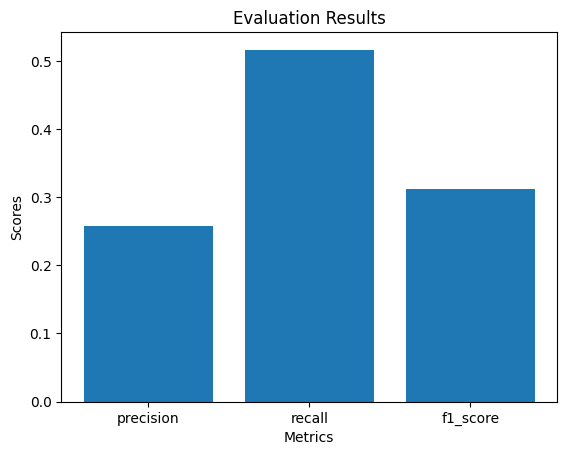

In [13]:
import matplotlib.pyplot as plt

results = {'precision': 0.25789082819723796, 'recall': 0.5167212227219724, 'f1_score': 0.3127440310170613}

# Extract the values
metrics = list(results.keys())
scores = list(results.values())

# Create the bar plot
plt.bar(metrics, scores)
plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('Evaluation Results')
plt.show()


In [5]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

def calculate_average_cosine_similarity(medlm_outputs, reference_texts):
    """
    Calculates the average cosine similarity between MedLM outputs and reference texts.

    Args:
        medlm_outputs: A list of MedLM outputs.
        reference_texts: A list of lists, where each inner list contains the reference texts for a corresponding MedLM output.

    Returns:
        The average cosine similarity.
    """

    cosine_similarity_results = []

    for i, medlm_output in enumerate(medlm_outputs):
        refs = reference_texts[i]

        # Calculate cosine similarity for each reference text
        vectorizer = TfidfVectorizer()
        tfidf_matrix = vectorizer.fit_transform([medlm_output] + refs)
        cosine_sim = cosine_similarity(tfidf_matrix[0], tfidf_matrix[1:])
        cosine_similarity_results.append(np.mean(cosine_sim))  # Average across references

    # Calculate the overall average
    average_cosine_similarity = np.mean(cosine_similarity_results)

    return average_cosine_similarity

# Example usage:
reference_texts = [["The medication 'Papain 2.5 % Solution' was used to treat a patient with id 12749568, who was admitted on 2136-11-09"],
                   ["The most frequently prescribed prescription drug is Insulin."],
                   ["The most frequent order types in provider order entries are: 1. Medications with 17690066 entries 2. Lab with 6565578 entries 3. General Care with 5690221 entries 4. ADT orders with 2171456 entries 5. IV therapy with 2140236 entries"],
                   ["The unique names of the tests given to patients who were admitted and the doctor comments VRE isolated are 'R/O VANCOMYCIN RESISTANT ENTEROCOCCUS', 'WOUND CULTURE', and 'FECAL CULTURE - R/O VIBRIO'"],
                   ["The radiology findings of a patient who received ORTHOPAEDICS service in discharge text are: EXAMINATION:  CHEST (PORTABLE AP) INDICATION:  ___ year old woman with urosepsis with fever rule out pneumonia TECHNIQUE:  CHEST (PORTABLE AP) COMPARISON:  ___ IMPRESSION:Left internal jugular line tip is at the level of mid SVC.  Cardiomegaly is substantial, unchanged."],
                   ["The radiology findings for the patient whose Chief Complaint was Abdominal pain in the discharge text were: EXAMINATION:  CT ABD AND PELVIS WITH CONTRAST INDICATION:  ___ with history of feeding tube, purulent drainage from wound site. Difficult venous access.NO_PO contrast Abscess?  G-tube placement? TECHNIQUE:  Single phase contrast: MDCT axial images were acquired through the abdomen and pelvis"],
                   ["The patient with note_id '17829563-RR-2' had a CT HEAD W/O CONTRAST examination where they found 'Routine unenhanced head CT was performed and viewed in brain, intermediate and bone windows.  Coronal and sagittal reformats were also performed. DOSE:  Total DLP (Head) = 903 mGy-cm. COMPARISON: ...'. The patient with note_id '14707889-RR-3' was indicated with 'History of hep C without treatment.  Presenting with abdominal\ndistension.  Question cirrhosis. COMPARISON:  None.FINDINGS:  The liver is shrunken and nodular in appearance consistent with\ncirrhosis.  There is no evidence of intrahepatic biliary duct dilatation."],
                   ["The radiology findings of a patient with a past medical history of coronary artery disease are as follows: There is a mild homogeneous plaque in the proximal internal carotid artery without significant increase in peak systolic velocities. The peak systolic velocity in the common carotid artery is 86 cm/sec."],
                   ["Two patients had allergies to Morphine. Their admission notes include the following information: 1. The first patient has an altered mental status and is in the MEDICINE department. No major surgical or invasive procedure was performed. 2. The second patient was admitted to the UROLOGY department for urinary incontinence. This patient is also allergic to Lipitor and Oxycodone, and no major surgical or invasive procedure was reported. The specific medications on admission for these patients are not provided in the available details."],
                   ["The three most frequent procedures are 'Venous catheterization, not elsewhere classified' with 13928 occurrences, 'Insertion of Infusion Device into Superior Vena Cava, Percutaneous Approach' with 10061 occurrences and 'Other nonoperative respiratory measurements' with 10041 occurrences."]
                   
                  ]
medlm_outputs = ["Papain 2.5% solution is a medication that is used to treat a variety of conditions. It is a proteolytic enzyme, which means that it helps to break down proteins. Papain is derived from the papaya fruit, and it has been used for centuries to treat a variety of medical conditions. Papain 2.5% solution can be used to treat a variety of conditions, including: Wounds: Papain can help to clean and debride wounds, and it can also help to promote healing. Skin conditions: Papain can be used to treat a variety of skin conditions, such as acne, eczema, and psoriasis. Digestive problems: Papain can help to improve digestion and relieve symptoms of indigestion, such as heartburn and bloating. Inflammation: Papain can help to reduce inflammation in the body. Papain 2.5% solution is a safe and effective medication that can be used to treat a variety of conditions. It is important to follow the directions on the medication label and to talk to your doctor or pharmacist if you have any questions about papain 2.5% solution.",
                "Insulin is a hormone that is produced by the pancreas and is essential for the body's use of glucose (sugar) for energy. It is used to treat diabetes, a condition in which the body does not produce enough insulin or does not use insulin effectively. Insulin is available in several different forms, including injectable, oral, and inhaled forms. The type and dose of insulin that is prescribed will depend on the individual's needs.",
                "The most frequent order types in provider order entries are: 1. Medications: 17690066 entries 2. Lab: 6565578 entries 3. General Care: 5690221 entries 4. ADT orders: 2171456 entries 5. IV therapy: 2140236 entries .Medications are the most common type of order, accounting for over half of all orders. This is likely due to the fact that medications are a common form of treatment for many different medical conditions. Lab orders are also common, as they are often used to diagnose and monitor medical conditions. General care orders include a variety of different types of orders, such as orders for diet, activity, and wound care. ADT orders are used to admit, discharge, and transfer patients. IV therapy is used to administer fluids and medications intravenously.",
                "Vancomycin-resistant Enterococcus (VRE) is a type of bacteria that is resistant to the antibiotic vancomycin. VRE can cause serious infections, especially in people who are hospitalized or have weakened immune systems. VRE is often found in hospitals and other healthcare settings, where it can be spread from person to person through contact with contaminated surfaces or objects. The tests listed above are used to diagnose VRE infections. The 'R/O VANCOMYCIN RESISTANT ENTEROCOCCUS' test is a culture test that is used to identify VRE bacteria in a sample of stool, urine, or blood. The 'WOUND CULTURE' test is used to identify bacteria that may be causing an infection in a wound. The 'FECAL CULTURE - R/O VIBRIO' test is used to identify Vibrio bacteria, which can cause a type of food poisoning. If you have any questions about these tests, please talk to your doctor.",
                "There is no evidence of pneumonia on the chest X-ray. The patient has a large heart (cardiomegaly) and a sternal wire, which is likely from previous surgery. The tip of the left internal jugular line is in a good position.",
                "There is no clear indication for the CT scan. The patient has a history of feeding tube, purulent drainage from wound site, and difficult venous access. The CT scan was done to evaluate for an abscess or to guide placement of a gastrostomy tube. The CT scan showed a small amount of free fluid in the right upper quadrant, which could be related to the patient's history of abdominal pain. There was no evidence of an abscess or other abnormality.",
                "One of the patients had a CT scan of the head without contrast, which showed no abnormalities. The other patient had an ultrasound of the abdomen, which showed a shrunken and nodular liver consistent with cirrhosis. There was no evidence of intrahepatic biliary duct dilatation. The common bile duct was mildly dilated at 8 mm. The gallbladder was distended with stones and sludge.",
                "The patient has a mild homogeneous plaque in the proximal internal carotid artery, which is the artery that supplies blood to the brain. This plaque does not appear to be causing any significant obstruction to blood flow, as the peak systolic velocity in the common carotid artery is normal. However, the patient's history of coronary artery disease suggests that they may be at increased risk of developing future cardiovascular events, such as a stroke or heart attack. It is important for the patient to continue to follow up with their doctor and manage their risk factors for cardiovascular disease, such as high blood pressure, high cholesterol, and diabetes.",
                "Given the limited information provided, it is not possible to provide a detailed summary of the patients' medical history or treatment plan. However, based on the information provided, it is possible to make some general observations.\n\nFirst, both patients have an allergy to morphine, which is a common opioid pain medication. This means that they should not be given morphine or other opioids, as they may experience a serious allergic reaction.Second, the first patient has an altered mental status, which can be a sign of a variety of underlying medical conditions. The cause of the altered mental status is not clear from the information provided, but it is important for the patient to be evaluated by a doctor to determine the cause and receive appropriate treatment.\n\nThird, the second patient was admitted for urinary incontinence, which is a common problem that can affect people of all ages. The cause of the urinary incontinence is not clear from the information provided, but it is important for the patient to be evaluated by a doctor to determine the cause and receive appropriate treatment.\n\nOverall, the information provided is limited, and it is not possible to provide a detailed summary of the patients' medical history or treatment plan. However, based on the information provided, it is possible to make some general observations about the patients' conditions and the need for further evaluation and treatment.",
                "The three most frequent procedures are 'Venous catheterization, not elsewhere classified' with 13928 occurrences, 'Insertion of Infusion Device into Superior Vena Cava, Percutaneous Approach' with 10061 occurrences and 'Other nonoperative respiratory measurements' with 10041 occurrences. 'Venous catheterization, not elsewhere classified' is the insertion of a catheter into a vein. It is a common procedure that is used for a variety of purposes, such as administering fluids, medications, or blood products, or for collecting blood samples.'Insertion of Infusion Device into Superior Vena Cava, Percutaneous Approach' is the placement of a catheter into the superior vena cava, a large vein that carries blood from the upper body to the heart. This procedure is often used to administer fluids, medications, or nutrition to patients who are unable to receive them through their veins.'Other nonoperative respiratory measurements' is a broad category that includes a variety of tests that are used to assess the function of the lungs. These tests may be used to diagnose respiratory conditions, such as asthma or chronic obstructive pulmonary disease (COPD), or to monitor the progress of a patient's treatment."
                ]
average_similarity = calculate_average_cosine_similarity(medlm_outputs, reference_texts)
print(f"Average Cosine Similarity: {average_similarity}")


Average Cosine Similarity: 0.38580754906200687


In [2]:
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction

reference_texts = [["The medication 'Papain 2.5 % Solution' was used to treat a patient with id 12749568, who was admitted on 2136-11-09"],
                   ["The most frequently prescribed prescription drug is Insulin."],
                   ["The most frequent order types in provider order entries are: 1. Medications with 17690066 entries 2. Lab with 6565578 entries 3. General Care with 5690221 entries 4. ADT orders with 2171456 entries 5. IV therapy with 2140236 entries"],
                   ["The unique names of the tests given to patients who were admitted and the doctor comments VRE isolated are 'R/O VANCOMYCIN RESISTANT ENTEROCOCCUS', 'WOUND CULTURE', and 'FECAL CULTURE - R/O VIBRIO'"],
                   ["The radiology findings of a patient who received ORTHOPAEDICS service in discharge text are: EXAMINATION:  CHEST (PORTABLE AP) INDICATION:  ___ year old woman with urosepsis with fever rule out pneumonia TECHNIQUE:  CHEST (PORTABLE AP) COMPARISON:  ___ IMPRESSION:Left internal jugular line tip is at the level of mid SVC.  Cardiomegaly is substantial, unchanged."],
                   ["The radiology findings for the patient whose Chief Complaint was Abdominal pain in the discharge text were: EXAMINATION:  CT ABD AND PELVIS WITH CONTRAST INDICATION:  ___ with history of feeding tube, purulent drainage from wound site. Difficult venous access.NO_PO contrast Abscess?  G-tube placement? TECHNIQUE:  Single phase contrast: MDCT axial images were acquired through the abdomen and pelvis"],
                   ["The patient with note_id '17829563-RR-2' had a CT HEAD W/O CONTRAST examination where they found 'Routine unenhanced head CT was performed and viewed in brain, intermediate and bone windows.  Coronal and sagittal reformats were also performed. DOSE:  Total DLP (Head) = 903 mGy-cm. COMPARISON: ...'. The patient with note_id '14707889-RR-3' was indicated with 'History of hep C without treatment.  Presenting with abdominal\ndistension.  Question cirrhosis. COMPARISON:  None.FINDINGS:  The liver is shrunken and nodular in appearance consistent with\ncirrhosis.  There is no evidence of intrahepatic biliary duct dilatation."],
                   ["The radiology findings of a patient with a past medical history of coronary artery disease are as follows: There is a mild homogeneous plaque in the proximal internal carotid artery without significant increase in peak systolic velocities. The peak systolic velocity in the common carotid artery is 86 cm/sec."],
                   ["Two patients had allergies to Morphine. Their admission notes include the following information: 1. The first patient has an altered mental status and is in the MEDICINE department. No major surgical or invasive procedure was performed. 2. The second patient was admitted to the UROLOGY department for urinary incontinence. This patient is also allergic to Lipitor and Oxycodone, and no major surgical or invasive procedure was reported. The specific medications on admission for these patients are not provided in the available details."],
                   ["The three most frequent procedures are 'Venous catheterization, not elsewhere classified' with 13928 occurrences, 'Insertion of Infusion Device into Superior Vena Cava, Percutaneous Approach' with 10061 occurrences and 'Other nonoperative respiratory measurements' with 10041 occurrences."]
                   
                  ]
medlm_outputs = ["Papain 2.5% solution is a medication that is used to treat a variety of conditions. It is a proteolytic enzyme, which means that it helps to break down proteins. Papain is derived from the papaya fruit, and it has been used for centuries to treat a variety of medical conditions. Papain 2.5% solution can be used to treat a variety of conditions, including: Wounds: Papain can help to clean and debride wounds, and it can also help to promote healing. Skin conditions: Papain can be used to treat a variety of skin conditions, such as acne, eczema, and psoriasis. Digestive problems: Papain can help to improve digestion and relieve symptoms of indigestion, such as heartburn and bloating. Inflammation: Papain can help to reduce inflammation in the body. Papain 2.5% solution is a safe and effective medication that can be used to treat a variety of conditions. It is important to follow the directions on the medication label and to talk to your doctor or pharmacist if you have any questions about papain 2.5% solution.",
                "Insulin is a hormone that is produced by the pancreas and is essential for the body's use of glucose (sugar) for energy. It is used to treat diabetes, a condition in which the body does not produce enough insulin or does not use insulin effectively. Insulin is available in several different forms, including injectable, oral, and inhaled forms. The type and dose of insulin that is prescribed will depend on the individual's needs.",
                "The most frequent order types in provider order entries are: 1. Medications: 17690066 entries 2. Lab: 6565578 entries 3. General Care: 5690221 entries 4. ADT orders: 2171456 entries 5. IV therapy: 2140236 entries .Medications are the most common type of order, accounting for over half of all orders. This is likely due to the fact that medications are a common form of treatment for many different medical conditions. Lab orders are also common, as they are often used to diagnose and monitor medical conditions. General care orders include a variety of different types of orders, such as orders for diet, activity, and wound care. ADT orders are used to admit, discharge, and transfer patients. IV therapy is used to administer fluids and medications intravenously.",
                "Vancomycin-resistant Enterococcus (VRE) is a type of bacteria that is resistant to the antibiotic vancomycin. VRE can cause serious infections, especially in people who are hospitalized or have weakened immune systems. VRE is often found in hospitals and other healthcare settings, where it can be spread from person to person through contact with contaminated surfaces or objects. The tests listed above are used to diagnose VRE infections. The 'R/O VANCOMYCIN RESISTANT ENTEROCOCCUS' test is a culture test that is used to identify VRE bacteria in a sample of stool, urine, or blood. The 'WOUND CULTURE' test is used to identify bacteria that may be causing an infection in a wound. The 'FECAL CULTURE - R/O VIBRIO' test is used to identify Vibrio bacteria, which can cause a type of food poisoning. If you have any questions about these tests, please talk to your doctor.",
                "There is no evidence of pneumonia on the chest X-ray. The patient has a large heart (cardiomegaly) and a sternal wire, which is likely from previous surgery. The tip of the left internal jugular line is in a good position.",
                "There is no clear indication for the CT scan. The patient has a history of feeding tube, purulent drainage from wound site, and difficult venous access. The CT scan was done to evaluate for an abscess or to guide placement of a gastrostomy tube. The CT scan showed a small amount of free fluid in the right upper quadrant, which could be related to the patient's history of abdominal pain. There was no evidence of an abscess or other abnormality.",
                "One of the patients had a CT scan of the head without contrast, which showed no abnormalities. The other patient had an ultrasound of the abdomen, which showed a shrunken and nodular liver consistent with cirrhosis. There was no evidence of intrahepatic biliary duct dilatation. The common bile duct was mildly dilated at 8 mm. The gallbladder was distended with stones and sludge.",
                "The patient has a mild homogeneous plaque in the proximal internal carotid artery, which is the artery that supplies blood to the brain. This plaque does not appear to be causing any significant obstruction to blood flow, as the peak systolic velocity in the common carotid artery is normal. However, the patient's history of coronary artery disease suggests that they may be at increased risk of developing future cardiovascular events, such as a stroke or heart attack. It is important for the patient to continue to follow up with their doctor and manage their risk factors for cardiovascular disease, such as high blood pressure, high cholesterol, and diabetes.",
                "Given the limited information provided, it is not possible to provide a detailed summary of the patients' medical history or treatment plan. However, based on the information provided, it is possible to make some general observations.\n\nFirst, both patients have an allergy to morphine, which is a common opioid pain medication. This means that they should not be given morphine or other opioids, as they may experience a serious allergic reaction.Second, the first patient has an altered mental status, which can be a sign of a variety of underlying medical conditions. The cause of the altered mental status is not clear from the information provided, but it is important for the patient to be evaluated by a doctor to determine the cause and receive appropriate treatment.\n\nThird, the second patient was admitted for urinary incontinence, which is a common problem that can affect people of all ages. The cause of the urinary incontinence is not clear from the information provided, but it is important for the patient to be evaluated by a doctor to determine the cause and receive appropriate treatment.\n\nOverall, the information provided is limited, and it is not possible to provide a detailed summary of the patients' medical history or treatment plan. However, based on the information provided, it is possible to make some general observations about the patients' conditions and the need for further evaluation and treatment.",
                "The three most frequent procedures are 'Venous catheterization, not elsewhere classified' with 13928 occurrences, 'Insertion of Infusion Device into Superior Vena Cava, Percutaneous Approach' with 10061 occurrences and 'Other nonoperative respiratory measurements' with 10041 occurrences. 'Venous catheterization, not elsewhere classified' is the insertion of a catheter into a vein. It is a common procedure that is used for a variety of purposes, such as administering fluids, medications, or blood products, or for collecting blood samples.'Insertion of Infusion Device into Superior Vena Cava, Percutaneous Approach' is the placement of a catheter into the superior vena cava, a large vein that carries blood from the upper body to the heart. This procedure is often used to administer fluids, medications, or nutrition to patients who are unable to receive them through their veins.'Other nonoperative respiratory measurements' is a broad category that includes a variety of tests that are used to assess the function of the lungs. These tests may be used to diagnose respiratory conditions, such as asthma or chronic obstructive pulmonary disease (COPD), or to monitor the progress of a patient's treatment."
                ]
# Calculate BLEU score
smoothie = SmoothingFunction().method4
bleu_score = sentence_bleu(reference_texts, medlm_output, smoothing_function=smoothie)

print(f"BLEU Score: {bleu_score}")

BLEU Score: 0
